Base price P: 2.4191
Prices: [np.float64(0.6048), np.float64(1.2096), np.float64(2.4191), np.float64(3.6287), np.float64(5.443)]


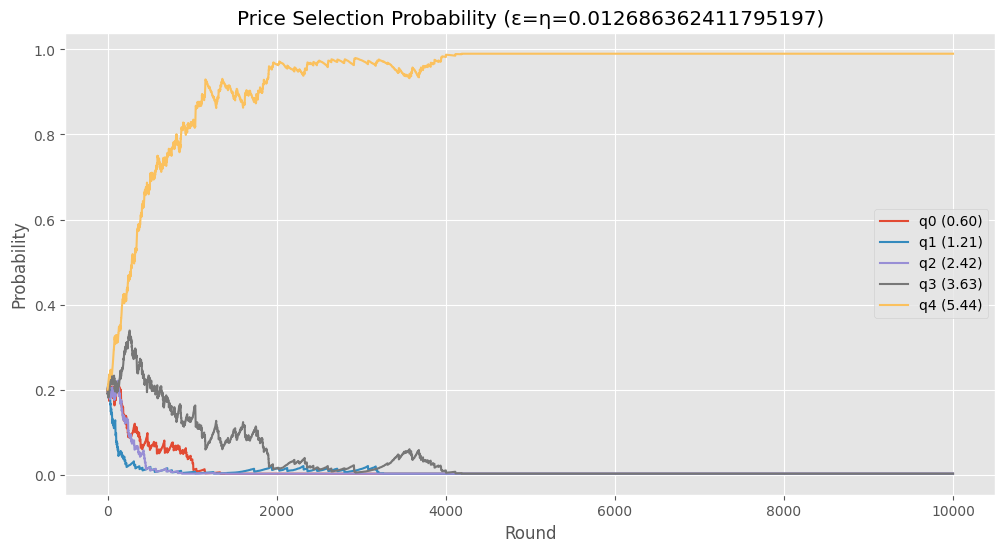

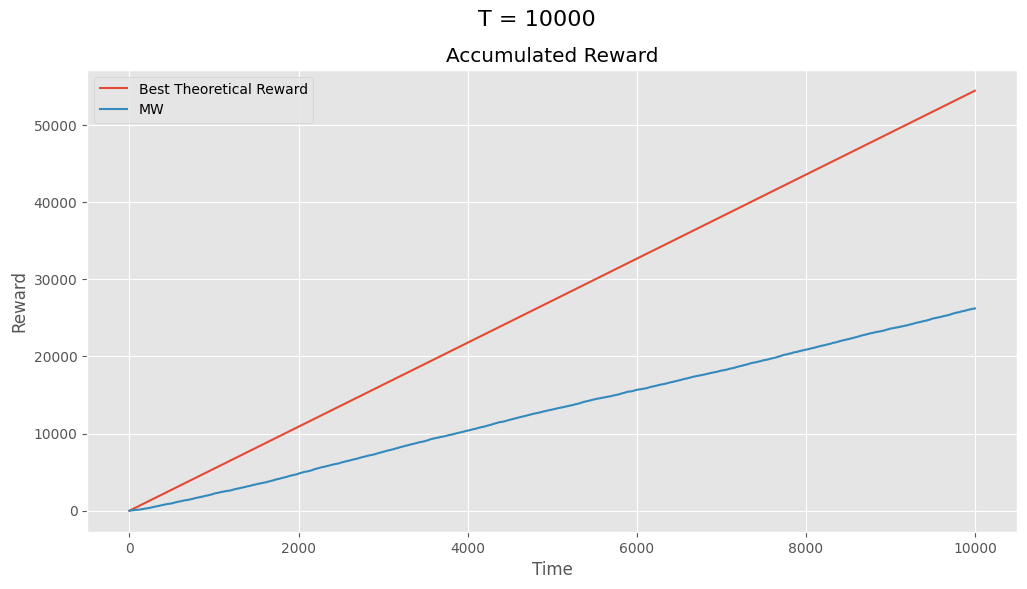

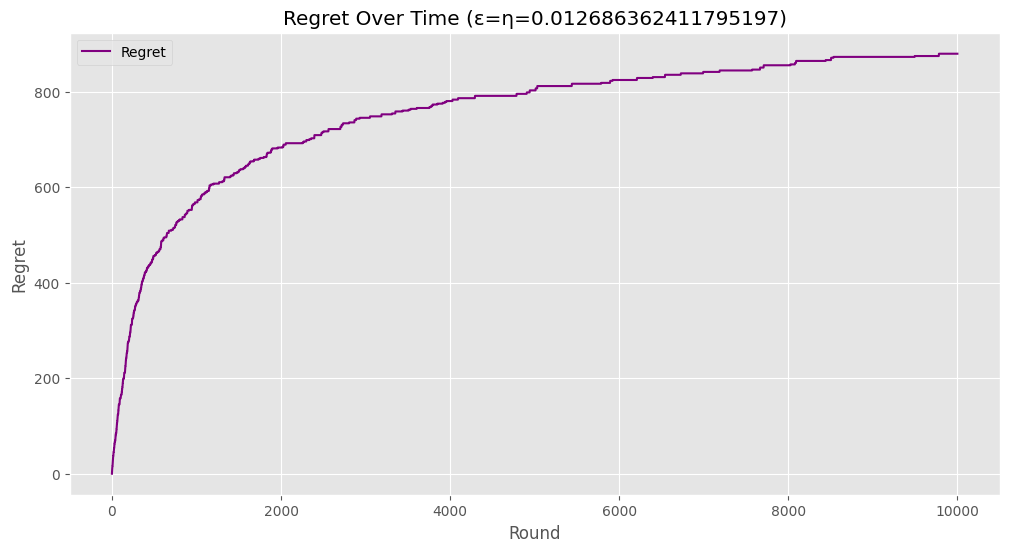

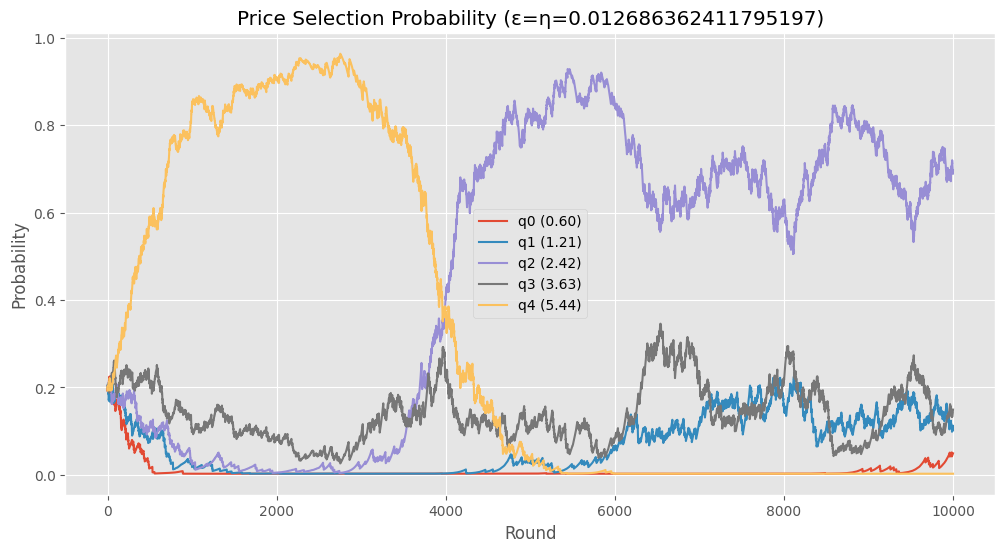

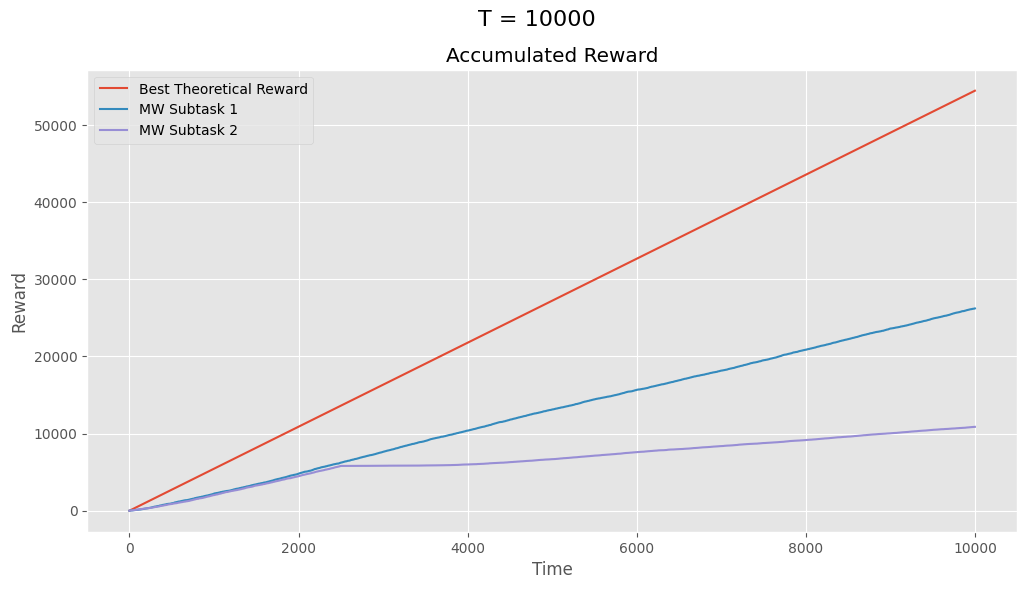

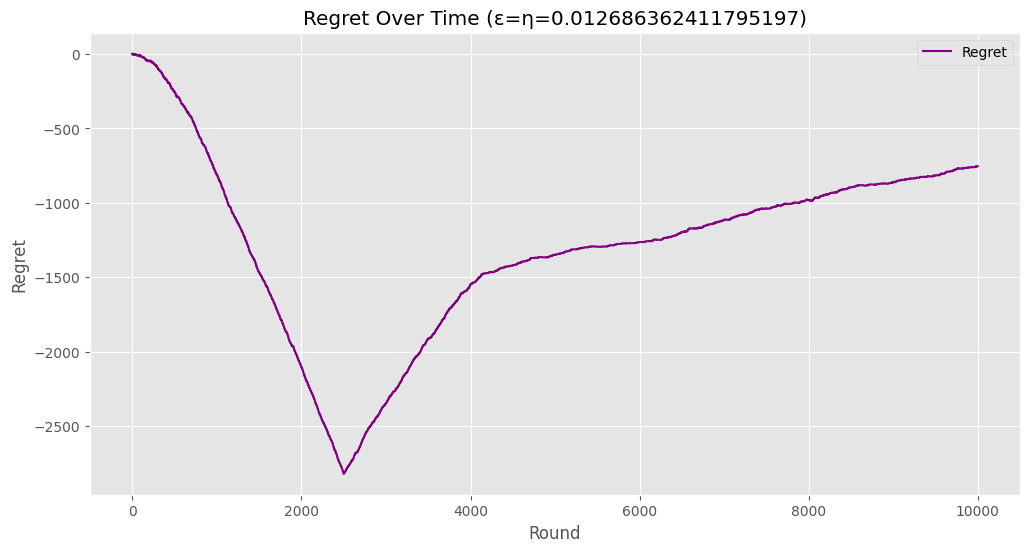

In [1]:
# Reinforcement Learning and Dynamic Optimization
# Assignment 2: Price Optimization Using Bandits
# Algorithm used:  Multiplicative Weights.

# Lamprakis Michalis 2020030077.    (22/3/2025)


# Import libraries and set plotting style.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style

np.random.seed(77) # my AM 2020030077
style.use('ggplot')

P = np.random.uniform(1.5, 2.5)
print("Base price P:", round(P,4))  # Choose Base price P uniformly in [1.5, 2.5].

alpha, beta = 0.5, 1.5
prices = np.array([ alpha**2 * P, alpha * P, P, beta * P, beta**2 * P]) # The possible price options for my service.
print("Prices:", [round(p, 4) for p in prices])

k = len(prices)               # Numer of arms.
p_max = np.max(prices)        # The maximum price.


#-------------------Subtask 1---------------------#
# The user however is “naive” and picks randomly
# between the two sellers.


# MW algorithm parameters.
T = 10000                                          # Number of rounds.
eta = epsilon= np.sqrt(np.log(k) / T)              # η ,  ε



weights = np.ones(k)     # Stores the weights of each arm at round t.
prob_history = []        # The history of probabilities qi(t) (helps us to track the progression of the algorithm).
rewards = []             # Rewards at each time step.
r_total = np.zeros(T)    # This will store the total accumulated rewards.

user_choices = []  # Track user choices (0 = competitor, 1 = you). Helps us findimg the L_OPT

for t in range(T):
   # Original MW probabilities ( pi(t) )
   prob = weights / np.sum(weights)

   # Add exploration: qi(t) = (1 - ε)pi(t) + ε/k
   q = (1 - epsilon) * prob + epsilon / k
   prob_history.append(q)  # Track probabilities (help us in the plot).

   # Choose arm based on qi(t)
   action = np.random.choice(k, p=q)

   # The user picks randomly between the two sellers.
   if np.random.rand() < 0.5:
      reward = prices[action]
      user_choice = 1  # User chose you (1).
   else:
      reward = 0
      user_choice = 0  # User chose competitor (0).

   user_choices.append(user_choice)
   rewards.append(reward)

   # Turn reward into loss (comparing it to the max possible reward i could have and normalize it.  li(t) ∈ [0, 1] )
   loss = (p_max - reward) / p_max

   # Update estimated loss \hat{ li(t) } = li(t) / qi(t) for picked arm only. The others remain the same.
   if q[action] > 0:
      estimated_loss = loss / q[action]
   else:
      estimated_loss = 0

   # Update the weight of the played arm only  [ (1 - η)^(\hat{li(t)}) * wi(t) ]
   weights[action] *= (1 - eta) ** estimated_loss

r_total = np.cumsum(rewards) # Stores accumulated rewards.



# Calculate L_ALG and L_OPT for regret
#   Lalg: The total accumulated loss of the algorithm.
#   Lopt: The loss of the optimal armed (the arm with the lower acummulated loss) if played for the whole rounds. Calculated after the end of the game.

# Calculate L_ALG
losses_alg = p_max - np.array(rewards)
cumulative_loss_alg = np.cumsum(losses_alg) # Algorithm's cumulative loss

# After played the game we can find L_OPT
# To caclulate L_OPT we need to compute the hypothetical losses for all arms
# if played for the whole game and find the one with the minimum accumulated loss.


hypothetical_losses = np.zeros((k, T)) # Stores the hypothetical losses, if one arm was played in the whole game.

# We user user_choices array so we simulate the same "stocastic enviroment" as the "real" game.
# Repeat for all arms.
for i in range(k):
    for t in range(T):
        if user_choices[t] == 1:      # If user at t choosed me give the reward of the arm.
            reward_i_t = prices[i]
        else:
            reward_i_t = 0            # If the user choosed the opponent give 0 reward.

        hypothetical_losses[i, t] = p_max - reward_i_t


# Compute total cumulative loss for each arm over all T rounds (thats why axis = 1).
# For example hypothetical_losses = [ (1,1,0,2,2), (1,0,0,5,7) ] the sums is [2,1,0,7,9] so this way we can find the minimum loss.
total_loss_per_arm = np.sum(hypothetical_losses, axis=1)
best_arm_index = np.argmin(total_loss_per_arm)  # Find the index of the i* (optimal arm.)

# Cumulative loss of the optimal arm i* over all T rounds.
cumulative_loss_opt_best_arm = np.cumsum(hypothetical_losses[best_arm_index, :])

# Regret = L_ALG-L_OPT
regret = cumulative_loss_alg - cumulative_loss_opt_best_arm


#--------------------PLOTS---------------------#

# Using prob_history (the probabilites q(i) of each arm) helps us to see how the algorithm progress over time.
plt.figure(figsize=(12, 6))
# For each arm print the right collumn of the table.
for i in range(k):
    plt.plot(np.array(prob_history)[:, i], label=f'q{i} ({prices[i]:.2f})')
plt.xlabel('Round')
plt.ylabel('Probability')
plt.title(f'Price Selection Probability (ε=η={epsilon})')
plt.legend()
plt.grid(True)
plt.show()

# Cumulative reward plot
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle(f"T = {T}", fontsize=16)
x = np.arange(T)

# The best theoretical reward it could be. If the user ALWAYS choose the most expensive arm.
best = x * p_max

ax.plot(x, best, label='Best Theoretical Reward')
ax.plot(x, r_total, label='MW')  # Add this line
ax.set_xlabel('Time')
ax.set_ylabel('Reward')
ax.set_title('Accumulated Reward')

ax.legend()
plt.show()

# Regret Plot
plt.figure(figsize=(12, 6))
plt.plot(regret, color='purple', label='Regret')
plt.xlabel('Round')
plt.ylabel('Regret')
plt.title(f'Regret Over Time (ε=η={epsilon})')
plt.legend()
plt.grid(True)
plt.show()



#-------------------Subtask 2---------------------#
# The user is “naive” and picks randomly for the fisrt T/4 and then
# starts picking the seller with the lower price.


# These 2 helps us to calculate the L_OPT in hindsight.
Q_history = [] # Store competitor prices (Q) for all rounds
user_choices = []  # Track user choices (0 = competitor, 1 = you)


# Initialize new MW parameters
weights = np.ones(k)
prob_history = []
rewards = []
r_total_2 = np.zeros(T)

for t in range(T):
    # Original MW probabilities (pi(t))
    prob = weights / np.sum(weights)

    # Add exploration: qi(t) = (1 - ε)pi(t) + ε/k
    q = (1 - epsilon) * prob + epsilon / k
    prob_history.append(q)  # Track exploration-augmented probabilities

    # Choose arm based on qi(t)
    action = np.random.choice(k, p=q)

    # Determine reward based on user behavior
    # For the first T/4 the user picks randomly.
    # Also stores the user_choice to caclulate L_OPT in hindsight.
    if t < T // 4:

         if np.random.rand() < 0.5:
              reward = prices[action]
              user_choice = 1  # User chose you (1).
         else:
              reward = 0
              user_choice = 0  # User chose competitor (0).

         user_choices.append(user_choice)

    # For the rest the user becomes "smart" and choose the cheapest option.
    else:
         # Random price Q drawn from a uniform distribution in [0, 4].
         Q = np.random.uniform(0, 4)
         Q_history.append(Q) # Stores it to help us find the L_OPT

         # User chooses the cheapest option.
         if prices[action] < Q:
            reward = prices[action]
         else:
            reward = 0

    rewards.append(reward)

    # Turn reward into loss (comparing it to the max possible reward i could have and normalize it.  li(t) ∈ [0, 1] )
    loss = (p_max - reward) / p_max

    # Update estimated loss \hat{ li(t) } = li(t) / qi(t) for picked arm only. The others remain the same.
    if q[action] > 0:
        estimated_loss = loss / q[action]
    else:
        estimated_loss = 0

     # Update the weight of the played arm only  [ (1 - η)^(\hat{li(t)}) * wi(t) ]
    weights[action] *= (1 - eta) ** estimated_loss

r_total_2 = np.cumsum(rewards)  # Accumulated rewards


# Calculate L_ALG and L_OPT for regret. Exaclty the same logic as before.
#   Lalg: The total accumulated loss of the algorithm.
#   Lopt: The loss of the optimal armed (the arm with the lower acummulated loss) if played for the whole rounds. Calculated after the end of the game.

# Algorithm's cumulative loss
losses_alg = p_max - np.array(rewards)
cumulative_loss_alg = np.cumsum(losses_alg)

# Compute hypothetical losses for all arms (L_OPT)
hypothetical_losses = np.zeros((k, T))

# The same as before, but for the first T/4 rounds use the user_choices as the user is naive
# and for the rest use Q_history to simulate the "smart user".
for i in range(k):
    for t in range(T):
        if t < T // 4:
            if user_choices[t] == 1:
                reward_i_t = prices[i]
            else:
                reward_i_t = 0
            hypothetical_losses[i, t] = p_max - reward_i_t
        else:
            Q = Q_history[t - T//4]
            if prices[i] < Q:
                reward_i_t = prices[i]
            else:
                reward_i_t = 0
        hypothetical_losses[i, t] = p_max - reward_i_t


# Compute total cumulative loss for each arm over all T rounds
total_loss_per_arm = np.sum(hypothetical_losses, axis=1)
best_arm_index = np.argmin(total_loss_per_arm)

# Cumulative loss of the optimal arm i* over all T rounds
cumulative_loss_opt_best_arm = np.cumsum(hypothetical_losses[best_arm_index, :])

# Regret = L_ALG - L_OPT
regret = cumulative_loss_alg - cumulative_loss_opt_best_arm

# Plotting
plt.figure(figsize=(12, 6))
for i in range(k):
    plt.plot(np.array(prob_history)[:, i], label=f'q{i} ({prices[i]:.2f})')
plt.xlabel('Round')
plt.ylabel('Probability')
plt.title(f'Price Selection Probability (ε=η={epsilon})')
plt.legend()
plt.grid(True)
plt.show()

# Cumulative reward plot
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle(f"T = {T}", fontsize=16)
x = np.arange(T)

best = x * p_max  # Theoretical maximum (if users always chose me)

ax.plot(x, best, label='Best Theoretical Reward')
ax.plot(x, r_total, label='MW Subtask 1')
ax.plot(x, r_total_2, label='MW Subtask 2')
ax.set_xlabel('Time')
ax.set_ylabel('Reward')
ax.set_title('Accumulated Reward')
ax.legend()

plt.show()



# Regret Plot
plt.figure(figsize=(12, 6))
plt.plot(regret, color='purple', label='Regret')
plt.xlabel('Round')
plt.ylabel('Regret')
plt.title(f'Regret Over Time (ε=η={epsilon})')
plt.legend()
plt.grid(True)
plt.show()
